In [3]:
import pandas as pd
import numpy as np

# === 1. Load dataset ===
df = pd.read_csv("/Users/qianrunchen/Downloads/Joseph_John_Andrew_Qianrun_DataSci_proj/data/merged_gdf.csv")

# === 2. Identify heavy metal columns ===
# Columns ending with "tot" or "sol" + 'Hg LL'
heavy_metal_cols = [col for col in df.columns 
                    if any(key in col for key in ['tot', 'sol', 'Hg'])]

print("Heavy metal columns:", heavy_metal_cols)

# === 3. Convert string values like '<0.3' or '<1' into numeric ===
def clean_value(x):
    if isinstance(x, str) and x.startswith('<'):
        # Use half of detection limit
        return float(x[1:]) / 2
    try:
        return float(x)
    except:
        return np.nan

for col in heavy_metal_cols:
    df[col] = df[col].apply(clean_value)

# === 4. Standardize heavy metal variables (Z-score) ===
df_standardized = df.copy()
for col in heavy_metal_cols:
    mean_val = df[col].mean()
    std_val = df[col].std()
    df_standardized[col + '_zscore'] = (df[col] - mean_val) / std_val

# === 5. Export new dataset ===
output_path = "/Users/qianrunchen/Downloads/Joseph_John_Andrew_Qianrun_DataSci_proj/data/new_merged_gdf.csv"
df_standardized.to_csv(output_path, index=False)

output_path


Heavy metal columns: ['As sol', 'Ba tot', 'Cu sol', 'Fe sol', 'Mn sol', 'Ni sol', 'Zn sol', 'Hg LL', 'Ca tot', 'Mg tot', 'B tot']


'/Users/qianrunchen/Downloads/Joseph_John_Andrew_Qianrun_DataSci_proj/data/new_merged_gdf.csv'

In [7]:
import pandas as pd
import numpy as np

# === 1. Load standardized dataset ===
path = "/Users/qianrunchen/Downloads/Joseph_John_Andrew_Qianrun_DataSci_proj/data/new_merged_gdf.csv"
df = pd.read_csv(path)

# === 2. Clean column names ===
df.columns = df.columns.str.strip()

# === 3. Identify z-score columns for heavy metals ===
zscore_cols = [col for col in df.columns if col.endswith("_zscore")]

# === 4. Convert time column and extract year ===
df["Collect"] = pd.to_datetime(df["Collect"], errors="coerce")
df["Year"] = df["Collect"].dt.year

# === 5. Determine the latest year in the dataset ===
latest_year = df["Year"].max()

# === 6. Select only the last 5 years ===
last_5_years = list(range(latest_year - 4, latest_year + 1))
df_5y = df[df["Year"].isin(last_5_years)]

# === 7. Compute mean Z-score for each heavy metal per year ===
yearly_mean_z = df_5y.groupby("Year")[zscore_cols].mean()

# === 8. Compute a combined pollution index (mean of all z-scores) ===
yearly_mean_z["Pollution_Index"] = yearly_mean_z.mean(axis=1)

# === 9. Sort the last 5 years by pollution severity ===
ranked_5_years = yearly_mean_z.sort_values("Pollution_Index", ascending=False)

# === 10. Print results ===
print("Five-year pollution ranking (highest to lowest):\n")
print(ranked_5_years)


Five-year pollution ranking (highest to lowest):

      As sol_zscore  Ba tot_zscore  Cu sol_zscore  Fe sol_zscore  \
Year                                                               
2021      -0.010849       0.214546      -0.024006      -0.016971   
2023       0.072869       0.041735       0.057093       0.046695   
2022       0.020097       0.151646       0.038655      -0.025224   
2020       0.155246      -0.125523       0.092985       0.038309   
2024      -0.225339      -0.257490      -0.154377      -0.041199   

      Mn sol_zscore  Ni sol_zscore  Zn sol_zscore  Hg LL_zscore  \
Year                                                              
2021       0.090618       0.394875       0.085566     -0.112230   
2023       0.010657      -0.142325       0.019542      0.099418   
2022      -0.001189      -0.096417       0.033818     -0.089112   
2020      -0.065640       0.115180       0.050830      0.146227   
2024      -0.028691      -0.210912      -0.180705     -0.048250   

   

In [10]:
import pandas as pd
import numpy as np

# === 1. Load standardized dataset ===
path = "/Users/qianrunchen/Downloads/Joseph_John_Andrew_Qianrun_DataSci_proj/data/new_merged_gdf.csv"
df = pd.read_csv(path)

# === 2. Clean column names and parse time ===
df.columns = df.columns.str.strip()
df["Collect"] = pd.to_datetime(df["Collect"], errors="coerce")

# === 3. Identify heavy-metal z-score columns ===
zscore_cols = [c for c in df.columns if c.endswith("_zscore")]

# === 4. Build a tidy anomaly-events table (one row = one anomaly of one metal) ===
records = []

for col in zscore_cols:
    metal = col.replace("_zscore", "")
    q75 = df[col].quantile(0.75)
    q90 = df[col].quantile(0.90)

    # 75th percentile anomalies (moderate)
    df75 = df[df[col] >= q75][["Collect", "Lat", "Lon", col]].copy()
    df75["metal"] = metal
    df75["threshold"] = "75th"
    df75 = df75.rename(columns={col: "zscore_value"})
    records.append(df75)

    # 90th percentile anomalies (severe)
    df90 = df[df[col] >= q90][["Collect", "Lat", "Lon", col]].copy()
    df90["metal"] = metal
    df90["threshold"] = "90th"
    df90 = df90.rename(columns={col: "zscore_value"})
    records.append(df90)

# Combine all anomaly events
events = pd.concat(records).sort_values("Collect").reset_index(drop=True)

# === 5. Add Year / Month / Season information ===
events["Year"] = events["Collect"].dt.year
events["Month"] = events["Collect"].dt.month

def month_to_season(m):
    """Return meteorological season name for a given month."""
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

events["Season"] = events["Month"].map(month_to_season)

# (Optional) If you ONLY want severe anomalies, uncomment this:
# events = events[events["threshold"] == "90th"]

# === 6. Count anomalies by Year-Month ===
month_counts = (
    events
    .groupby(["Year", "Month"])
    .size()
    .reset_index(name="n_anomalies")
    .sort_values("n_anomalies", ascending=False)
)

print("=== Year-Month anomaly ranking (most to least) ===")
print(month_counts.head(20))   # top 20 year-months

if not month_counts.empty:
    top_month = month_counts.iloc[0]
    print("\nYear-Month with MOST anomalies:")
    print(f"Year: {int(top_month['Year'])}, "
          f"Month: {int(top_month['Month'])}, "
          f"Anomalies: {int(top_month['n_anomalies'])}")

# === 7. Count anomalies by Year-Season ===
season_counts = (
    events
    .groupby(["Year", "Season"])
    .size()
    .reset_index(name="n_anomalies")
    .sort_values("n_anomalies", ascending=False)
)

print("\n=== Year-Season anomaly ranking (most to least) ===")
print(season_counts.head(20))  # top 20 year-seasons

if not season_counts.empty:
    top_season = season_counts.iloc[0]
    print("\nYear-Season with MOST anomalies:")
    print(f"Year: {int(top_season['Year'])}, "
          f"Season: {top_season['Season']}, "
          f"Anomalies: {int(top_season['n_anomalies'])}")


=== Year-Month anomaly ranking (most to least) ===
    Year  Month  n_anomalies
26  2022      3          260
14  2021      3          257
25  2022      2          241
37  2023      2          234
15  2021      4          204
1   2020      2          203
2   2020      3          198
36  2023      1          197
49  2024      2          190
16  2021      5          184
41  2023      6          181
40  2023      5          181
46  2023     11          177
12  2021      1          173
39  2023      4          172
10  2020     11          171
29  2022      6          167
27  2022      4          166
3   2020      4          165
35  2022     12          161

Year-Month with MOST anomalies:
Year: 2022, Month: 3, Anomalies: 260

=== Year-Season anomaly ranking (most to least) ===
    Year  Season  n_anomalies
5   2021  Spring          645
9   2022  Spring          575
15  2023  Winter          572
11  2022  Winter          536
1   2020  Spring          511
13  2023  Spring          504
12  202

=== Top 10 most abnormal locations ===
          Lat        Lon  n_anomalies
0   41.570589 -88.078319          848
33  42.059083 -87.956833          718
27  42.008264 -88.119111          445
2   41.631319 -87.539100          388
25  41.974983 -88.138625          385
29  42.018633 -87.936711          372
6   41.651678 -87.660592          366
30  42.021411 -87.940614          360
11  41.735642 -87.881478          298
26  41.992853 -87.995275          295


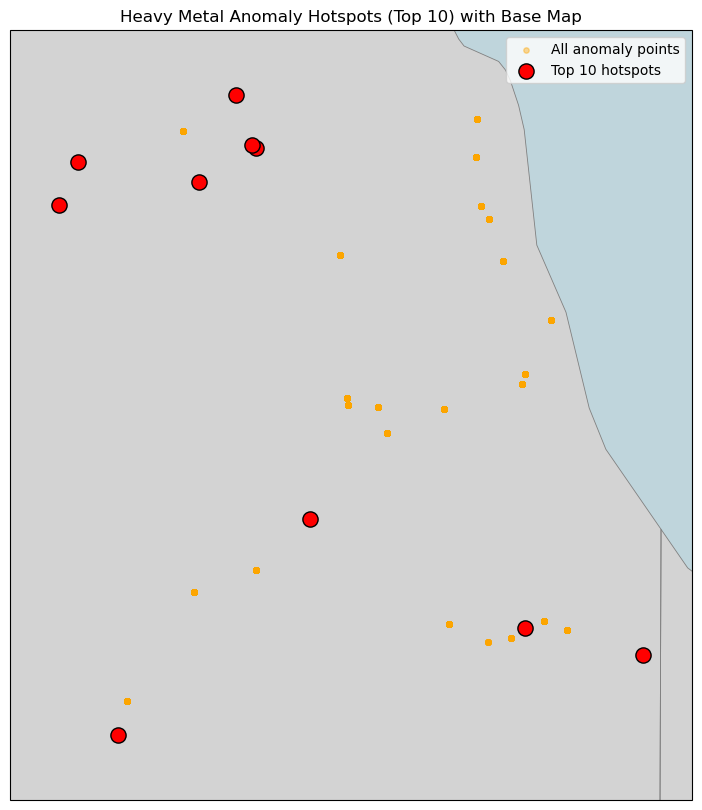

In [14]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === 1. Load standardized dataset ===
path = "/Users/qianrunchen/Downloads/Joseph_John_Andrew_Qianrun_DataSci_proj/data/new_merged_gdf.csv"
df = pd.read_csv(path)

# === 2. Clean column names & parse time ===
df.columns = df.columns.str.strip()
df["Collect"] = pd.to_datetime(df["Collect"], errors="coerce")

# === 3. Identify heavy-metal z-score columns ===
zscore_cols = [c for c in df.columns if c.endswith("_zscore")]

# === 4. Build anomaly table ===
records = []

for col in zscore_cols:
    metal = col.replace("_zscore", "")
    q75 = df[col].quantile(0.75)
    q90 = df[col].quantile(0.90)

    df75 = df[df[col] >= q75][["Collect", "Lat", "Lon", col]].copy()
    df75["metal"] = metal
    df75["threshold"] = "75th"
    df75 = df75.rename(columns={col: "zscore_value"})
    records.append(df75)

    df90 = df[df[col] >= q90][["Collect", "Lat", "Lon", col]].copy()
    df90["metal"] = metal
    df90["threshold"] = "90th"
    df90 = df90.rename(columns={col: "zscore_value"})
    records.append(df90)

# Final anomaly table
abnormal_all = pd.concat(records).reset_index(drop=True)

# === 5. Count anomalies by location ===
site_counts = (
    abnormal_all.groupby(["Lat", "Lon"])
    .size()
    .reset_index(name="n_anomalies")
    .sort_values("n_anomalies", ascending=False)
)

top10_sites = site_counts.head(10)

print("=== Top 10 most abnormal locations ===")
print(top10_sites)

# === 6. Convert into GeoDataFrame ===
gdf_all = gpd.GeoDataFrame(
    abnormal_all,
    geometry=gpd.points_from_xy(abnormal_all["Lon"], abnormal_all["Lat"]),
    crs="EPSG:4326"
)

gdf_top10 = gpd.GeoDataFrame(
    top10_sites,
    geometry=gpd.points_from_xy(top10_sites["Lon"], top10_sites["Lat"]),
    crs="EPSG:4326"
)

# === 7. Plot with Cartopy base map ===
plt.figure(figsize=(10, 10))

ax = plt.axes(projection=ccrs.PlateCarree())

# Add base layers
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.LAKES, facecolor="lightblue", alpha=0.5)
ax.add_feature(cfeature.RIVERS, edgecolor="blue", alpha=0.6)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.7)
ax.add_feature(cfeature.STATES, edgecolor="gray", linewidth=0.6)

# Limits (auto-fit your region)
minx, miny, maxx, maxy = gdf_all.total_bounds
ax.set_extent([minx - 0.05, maxx + 0.05, miny - 0.05, maxy + 0.05])

# Plot ALL anomaly points (light orange)
gdf_all.plot(
    ax=ax,
    markersize=15,
    color="orange",
    alpha=0.4,
    label="All anomaly points",
    transform=ccrs.PlateCarree()
)

# Plot TOP10 hotspot points (red, larger)
gdf_top10.plot(
    ax=ax,
    markersize=120,
    color="red",
    edgecolor="black",
    label="Top 10 hotspots",
    transform=ccrs.PlateCarree()
)

plt.title("Heavy Metal Anomaly Hotspots (Top 10) with Base Map")
plt.legend()
plt.show()


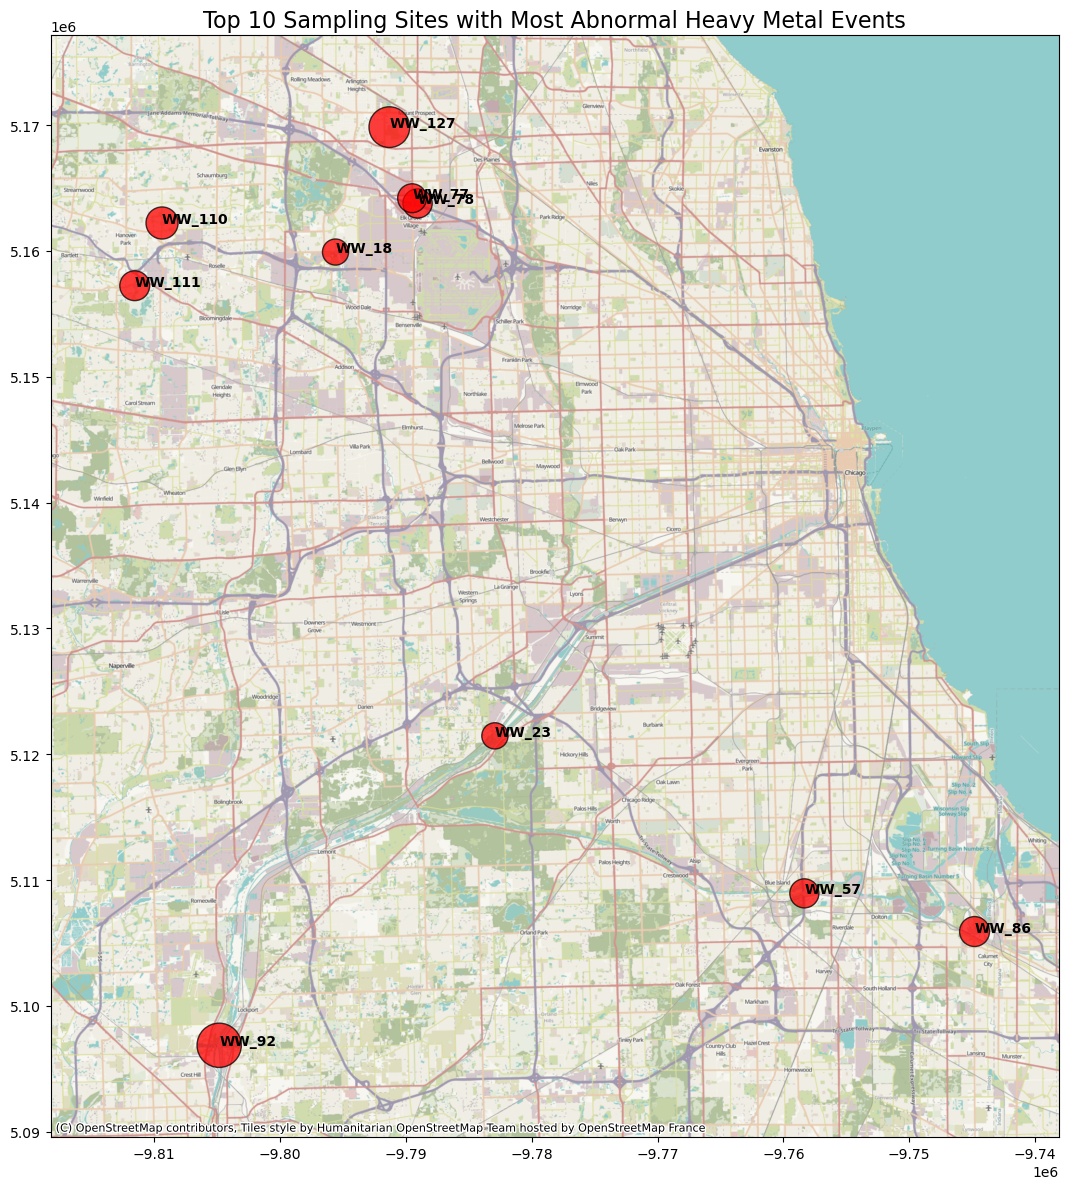

In [19]:
# =========================================
# Top 10 Most Abnormal Sampling Sites (Smaller Dots + Humanitarian Basemap)
# =========================================

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# 1) Top 10 sites 
top10_sites = (
    abnormal_out.groupby(['Sampling', 'Lat', 'Lon'])
    .size()
    .reset_index(name='Abnormal_Count')
    .sort_values('Abnormal_Count', ascending=False)
    .head(10)
)

# 2) All points → GeoDataFrame
gdf_all = gpd.GeoDataFrame(
    abnormal_out,
    geometry=gpd.points_from_xy(abnormal_out['Lon'], abnormal_out['Lat']),
    crs="EPSG:4326"
)

# 3) Top10 → GeoDataFrame
top10_gdf = gpd.GeoDataFrame(
    top10_sites,
    geometry=gpd.points_from_xy(top10_sites['Lon'], top10_sites['Lat']),
    crs="EPSG:4326"
)

# 4) Convert to Web Mercator (EPSG:3857)
gdf_all_3857 = gdf_all.to_crs(epsg=3857)
top10_gdf_3857 = top10_gdf.to_crs(epsg=3857)

# ---------------------------
# 5) Plot
# ---------------------------
fig, ax = plt.subplots(figsize=(12, 12))

# Set bounds similar to old map view
minx, miny, maxx, maxy = gdf_all_3857.total_bounds
pad_x = (maxx - minx) * 0.1
pad_y = (maxy - miny) * 0.1
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

# All abnormal points (smaller)
gdf_all_3857.plot(
    ax=ax,
    color='lightgray',
    markersize=3,
    alpha=0.4
)

# Top10 points (smaller scaling)
top10_gdf_3857.plot(
    ax=ax,
    color='red',
    edgecolor='black',
    markersize=top10_gdf_3857['Abnormal_Count'] * 1.2,
    alpha=0.75
)

# Add labels
for x, y, label in zip(top10_gdf_3857.geometry.x,
                       top10_gdf_3857.geometry.y,
                       top10_gdf_3857['Sampling']):
    ax.text(x, y, label, fontsize=10, color='black', weight='bold')

# 🔥 Use Humanitarian basemap (same as your screenshot)
ctx.add_basemap(
    ax,
    crs=gdf_all_3857.crs,
    source=ctx.providers.OpenStreetMap.HOT,
    zoom=12
)

plt.title("Top 10 Sampling Sites with Most Abnormal Heavy Metal Events", fontsize=16)
plt.tight_layout()
plt.show()
